##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

# Gesture Recognizer with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to recognize hand gestures in images.

## Preparation

Let's start with installing MediaPipe.

Then download an off-the-shelf model. This model can recognize 7 hand gestures: 👍, 👎, ✌️, ☝️, ✊, 👋, 🤟

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer#models) for more details about the model.

In [1]:
import urllib
url = f'https://storage.googleapis.com/mediapipe-models/gesture_recognizer/gesture_recognizer/float16/1/gesture_recognizer.task'
urllib.request.urlretrieve(url, 'gesture.task')

('gesture.task', <http.client.HTTPMessage at 0x1647cf591f0>)

## Download test images

Let's grab some test images that we'll use later. The images ([1](https://pixabay.com/photos/idea-pointing-raise-hand-raise-3082824/), [2](https://pixabay.com/photos/thumbs-up-happy-positive-woman-2649310/), [3](https://pixabay.com/photos/epidemic-disease-coronavirus-5082474/), [4](https://pixabay.com/photos/thumbs-down-disapprove-gesture-6744094/)) are from Pixabay.

In [2]:
import urllib

IMAGE_FILENAMES = ['thumbs_down.jpg', 'victory.jpg', 'thumbs_up.jpg', 'pointing_up.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/{name}'
  filename = './image/' + name
  urllib.request.urlretrieve(url, filename)



Then let's check out the images.

In [2]:
import cv2

import math

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480
IMAGE_FILENAMES = ['./image/thumbs_down.jpg', './image/victory.jpg', './image/thumbs_up.jpg', './image/pointing_up.jpg']

def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2.imshow('win',img)


# Preview the images.
images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
  print(name)
  resize_and_show(image)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  break

./image/thumbs_down.jpg


## Running inference and visualizing the results

Here are the steps to run gesture recognizer using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer/python) to learn more about configuration options that this solution supports.

*Note: Gesture Recognizer also returns the hand landmark it detects from the image, together with other useful information such as whether the hand(s) detected are left hand or right hand.*

### mediapipe 读取照片信息有些讲究
- 要么直接使用mp.Image.create_from_file 直接读取文件信息
- 要么使用cv读取后，先转换RGB，在使用Image API 

In [2]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
import traceback

base_options = python.BaseOptions(model_asset_path='./gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)

try: 
    frame = cv2.imread('./image/victory.jpg')
    h,w,c = frame.shape
    frame_copy = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #image1 = mp.Image.create_from_file('./image/victory.jpg')
    frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
    recognition_result = recognizer.recognize(frame)
    
    if recognition_result.hand_landmarks:
        hand_lm = recognition_result.hand_landmarks
        for i in hand_lm[0]:
            x,y = int(i.x * w), int(i.y * h)
            cv2.circle(frame_copy, (x,y), 1, (255,0,120), 3)

    if recognition_result.gestures:
        gesture = recognition_result.gestures[0][0].category_name
        print(gesture)
        handedness = recognition_result.handedness[0][0].category_name
        cv2.putText(frame_copy,gesture+'%'+handedness,(20,40), cv2.FONT_HERSHEY_COMPLEX, 1,(233,2,120),1)
        
    cv2.imshow('win', frame_copy)
    cv2.waitKey(0)
    
except Exception as e:
    mg = traceback.format_exc()
    print(f'error:{mg}')

cv2.destroyAllWindows()
print('perfect exit!')

Victory
perfect exit!


### 也可以采用mp_drawing.draw_handmarks的方式画图，只是需要做个前处理
- recognition_result.hand_landmarks 返回的一个[[]],因此需要两维度索引。具体内容如下：  
NormalizedLandmark(x=0.2899027168750763, y=0.7539041042327881, z=1.2974370520169032e-06, visibility=0.0, presence=0.0)
- hand_landmarks[0] 取到了一个包含了21个Normxxx的列表，可以通过hand_landmarks[0][1]的方式找到其中的一个坐标点。
- 26-31line代码体现了数据转换的方式，有兴趣的可以看下
- 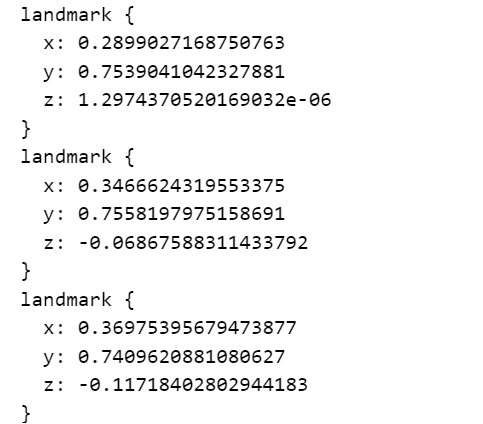

In [1]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
from mediapipe.framework.formats import landmark_pb2
import traceback

base_options = python.BaseOptions(model_asset_path='./gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)

try: 
    frame = cv2.imread('./image/victory.jpg')
    h,w,c = frame.shape
    frame_copy = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #image1 = mp.Image.create_from_file('./image/victory.jpg')
    frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
    recognition_result = recognizer.recognize(frame)
    
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles

    if recognition_result.hand_landmarks:
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()#实例化存储mark的对象
        hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in recognition_result.hand_landmarks[0]
          ])#将norm的形式转为正常形式
        mp_drawing.draw_landmarks(frame_copy, hand_landmarks_proto,mp_hands.HAND_CONNECTIONS)
        
    if recognition_result.gestures:
        gesture = recognition_result.gestures[0][0].category_name
        handedness = recognition_result.handedness[0][0].category_name
        cv2.putText(frame_copy,gesture+'%'+handedness,(20,40), cv2.FONT_HERSHEY_COMPLEX, 1,(233,2,120),1)
    cv2.imshow('win', frame_copy)
    cv2.waitKey(0)
    
except Exception as e:
    mg= traceback.format_exc()
    print(f'error:{mg}')

cv2.destroyAllWindows()
print('perfect exit!')

RuntimeError: Unable to open file at c:\Users\deep\Desktop\2025_AI001_交互技术(0305更新）\5-6. CNN与MobileNet、Mediapipe\AI1101_0401_code\Mediapipe\gesture_recognizer.task, errno=-1

### 读取视频代码，自行补充
- 注意一些数据的输出输出样式即可